In [1]:
import tensorflow as tf

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
n_gpus = len(os.environ['CUDA_VISIBLE_DEVICES'].split(','))

import keras.backend as K
#import tensorflow as tf

# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [3]:
import numpy as np
import pandas as pd
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import l2

from keras.preprocessing.image import *

import matplotlib.pyplot as plt
import random
import os
import cv2
from tqdm import tqdm
from glob import glob
import multiprocessing

from sklearn.model_selection import train_test_split
from collections import Counter
from keras import backend as K
from keras.utils import multi_gpu_model

from IPython.display import display, Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [4]:
df = pd.read_csv('data/Annotations/label.csv', header=None)
df.columns = ['filename', 'label_name', 'label']
df = df.sample(frac=1).reset_index(drop=True) # shuffle

df.label_name = df.label_name.str.replace('_labels', '')
df = df[df.label_name == 'neck_design']

display(df.head())
c = Counter(df.label_name)
c

,filename,label_name,label
2,Images/neck_design_labels/54379aaa265617bc3193...,neck_design,ynnnn
8,Images/neck_design_labels/f0a9baa9a6771f949eab...,neck_design,nnynn
26,Images/neck_design_labels/ff317ac985f5f185def5...,neck_design,nynnn
38,Images/neck_design_labels/efdb17bcf8ad00ffb6dc...,neck_design,ynnnn
40,Images/neck_design_labels/08abc65d474bed33bd00...,neck_design,nnynn


Counter({'neck_design': 5696})

In [5]:
label_count = dict([(x, len(df[df.label_name == x].label.values[0])) for x in c.keys()])
label_names = list(label_count.keys())
display(label_count)

{'neck_design': 5}

In [6]:
n = len(df)
print(n)

5696


In [7]:
fnames = df['filename'].values
width = 399

y = [np.zeros((n, label_count[x])) for x in label_count.keys()]
df = df.reset_index(drop=True)

In [8]:
for i in range(n):
    label_name = df.label_name[i]
    label = df.label[i]
    y[label_names.index(label_name)][i, label.find('y')] = 1
    #y[label_names.index(label_name)][i, label.find('m')] = 0.5

In [9]:
print(fnames[0:10])
print(n)
print(len(y[0]))
print(len(y))
print(label_count.keys())
print(len(y[0][0]))

['Images/neck_design_labels/54379aaa265617bc319393724ccde50c.jpg'
 'Images/neck_design_labels/f0a9baa9a6771f949eab310a316831c4.jpg'
 'Images/neck_design_labels/ff317ac985f5f185def591487684a7c0.jpg'
 'Images/neck_design_labels/efdb17bcf8ad00ffb6dc766a875e6ab2.jpg'
 'Images/neck_design_labels/08abc65d474bed33bd004aea5ca61848.jpg'
 'Images/neck_design_labels/17715fbfe5fb46ae787e07794ed0d068.jpg'
 'Images/neck_design_labels/eb102e594c1d3738c19aaa475e560334.jpg'
 'Images/neck_design_labels/92b5116525a0a8fdd7daa6c8a3b42da2.jpg'
 'Images/neck_design_labels/e5aa30806835b02cfd23b062868c45f1.jpg'
 'Images/neck_design_labels/65536bfdfbc06bd6b14a1818da28caeb.jpg']
5696
5696
1
dict_keys(['neck_design'])
5


In [10]:
def f(index):
    if os.path.isfile('data/'+fnames[index]):
        return index, cv2.resize(cv2.imread('data/'+fnames[index]), (width, width))

X = np.zeros((n, width, width, 3), dtype=np.uint8)
with multiprocessing.Pool(12) as pool:
    with tqdm(pool.imap_unordered(f, range(n)), total=n) as pbar:
        for i, img in pbar:
            X[i] = img[:,:,::-1]

100%|██████████| 5696/5696 [00:09<00:00, 574.31it/s]


In [11]:
n_train = int(n*0.8)

X_train = X[:n_train]
X_valid = X[n_train:]
y_train = [x[:n_train] for x in y]
y_valid = [x[n_train:] for x in y]

In [12]:
from dataset import *
gen_train = Generator(X_train, y_train, batch_size=32, aug=True)

In [13]:
base_model = ResNet50(weights='imagenet', input_shape=(width, width, 3), include_top=False, pooling='avg')

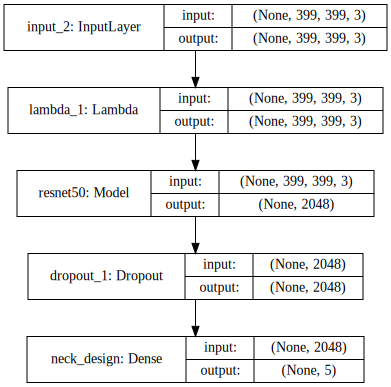

In [14]:
input_tensor = Input((width, width, 3))
x = input_tensor
x = Lambda(resnet50.preprocess_input)(x)
x = base_model(x)
x = Dropout(0.5)(x)
x = [Dense(count, activation='softmax', name=name)(x) for name, count in label_count.items()]

model = Model(input_tensor, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

plot_model(model, show_shapes=True, to_file='model_neck_design.png')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [15]:
model2 = multi_gpu_model(model, n_gpus)

In [16]:
model2.compile(optimizer = Adam(0.0001),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=8, validation_data=(X_valid, y_valid))

Epoch 1/8
143/143 [==============================] - 211s 1s/step - loss: 1.3038 - acc: 0.4735 - val_loss: 0.9287 - val_acc: 0.7254
Epoch 2/8
143/143 [==============================] - 168s 1s/step - loss: 0.8064 - acc: 0.6967 - val_loss: 0.8271 - val_acc: 0.7421
Epoch 3/8
143/143 [==============================] - 169s 1s/step - loss: 0.6284 - acc: 0.7705 - val_loss: 0.6120 - val_acc: 0.7833
Epoch 4/8
143/143 [==============================] - 168s 1s/step - loss: 0.5140 - acc: 0.8154 - val_loss: 0.7211 - val_acc: 0.7763
Epoch 5/8
143/143 [==============================] - 167s 1s/step - loss: 0.4066 - acc: 0.8537 - val_loss: 0.6071 - val_acc: 0.8018
Epoch 6/8
143/143 [==============================] - 168s 1s/step - loss: 0.3797 - acc: 0.8674 - val_loss: 0.6504 - val_acc: 0.7816
Epoch 7/8
143/143 [==============================] - 170s 1s/step - loss: 0.3365 - acc: 0.8787 - val_loss: 0.7655 - val_acc: 0.7895
Epoch 8/8
143/143 [==============================] - 170s 1s/step - loss: 0.

In [17]:
model2.compile(optimizer = Adam(0.000025),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=3, validation_data=(X_valid, y_valid))

Epoch 1/3
143/143 [==============================] - 205s 1s/step - loss: 0.2190 - acc: 0.9264 - val_loss: 0.5735 - val_acc: 0.8228
Epoch 2/3
143/143 [==============================] - 163s 1s/step - loss: 0.1391 - acc: 0.9530 - val_loss: 0.6198 - val_acc: 0.8263
Epoch 3/3
143/143 [==============================] - 167s 1s/step - loss: 0.1304 - acc: 0.9565 - val_loss: 0.6197 - val_acc: 0.8421


In [18]:
model2.compile(optimizer = Adam(0.00000625),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=3, validation_data=(X_valid, y_valid))

Epoch 1/3
143/143 [==============================] - 205s 1s/step - loss: 0.1155 - acc: 0.9589 - val_loss: 0.6054 - val_acc: 0.8421
Epoch 2/3
143/143 [==============================] - 168s 1s/step - loss: 0.1088 - acc: 0.9623 - val_loss: 0.5924 - val_acc: 0.8430
Epoch 3/3
143/143 [==============================] - 167s 1s/step - loss: 0.0964 - acc: 0.9696 - val_loss: 0.5987 - val_acc: 0.8395


In [19]:
model2.compile(optimizer = Adam(0.00000425),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=1, validation_data=(X_valid, y_valid))

Epoch 1/1
143/143 [==============================] - 208s 1s/step - loss: 0.1016 - acc: 0.9663 - val_loss: 0.6006 - val_acc: 0.8421


In [20]:
model2.compile(optimizer = Adam(0.000001),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=1, validation_data=(X_valid, y_valid))

Epoch 1/1
143/143 [==============================] - 213s 1s/step - loss: 0.0935 - acc: 0.9705 - val_loss: 0.6007 - val_acc: 0.8368


In [21]:
model_name = 'resnet_neck_design'

model.save('model_%s.h5' % model_name)